In [ ]:

%pip install transformers datasets evaluate accelerate -q

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import classification_report, accuracy_score
from evaluate import load as load_metric


%matplotlib inline


# Datensatz laden
data_path = "data/clean_books.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"{data_path} wurde nicht gefunden.")

raw = load_dataset("csv", data_files=data_path)["train"]
print(f"Datensatz geladen: {len(raw)} Bücher")


# Labels encodieren

genres = sorted(set(raw["genre"]))
num_labels = len(genres)
raw = raw.cast_column("genre", ClassLabel(names=genres))


#Train/Dev/Test

split1 = raw.train_test_split(test_size=0.30, seed=42, stratify_by_column="genre")
ds_train = split1["train"]
ds_rest  = split1["test"]
split2 = ds_rest.train_test_split(test_size=2/3, seed=42, stratify_by_column="genre")
ds_dev  = split2["train"]   # 10%
ds_test = split2["test"]    # 20%

dataset_dict = DatasetDict({
    "train": ds_train,
    "validation": ds_dev,
    "test": ds_test
})
print(f"Splits → Train: {len(ds_train)}, Val: {len(ds_dev)}, Test: {len(ds_test)}")


#Tokenizer & Modell vorbereiten

model_name = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=512)

tokenized = dataset_dict.map(tokenize, batched=True)
tokenized = tokenized.remove_columns(["title", "description", "text"])
tokenized = tokenized.rename_column("genre", "labels")
tokenized.set_format("torch")




data_collator   = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc   = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    return {"accuracy": acc}


# Hyperparameter‑Loop

learning_rates = [2e-5, 5e-5]
batch_sizes    = [8, 16]
best_val_acc   = 0.0
best_trainer   = None
results        = {}

for lr in learning_rates:
    for bs in batch_sizes:
        run_name = f"lr_{lr}_bs_{bs}"
        print(f"\n--- Training: {run_name} ---")
        model_tmp = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

        training_args = TrainingArguments(
            output_dir=f"./checkpoints/{run_name}",
            num_train_epochs=5,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            learning_rate=lr,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            greater_is_better=True,
            logging_dir=f"./logs/{run_name}",
            logging_strategy="epoch",
            save_total_limit=1,
            seed=42
        )

        trainer = Trainer(
            model=model_tmp,
            args=training_args,
            train_dataset=tokenized["train"],
            eval_dataset= tokenized["validation"],
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()
        val_res = trainer.evaluate(tokenized["validation"])
        val_acc = val_res["eval_accuracy"]
        results[run_name] = val_acc

        if val_acc > best_val_acc:
            best_val_acc  = val_acc
            best_trainer  = trainer

print(f"\nBestes Setup: {max(results, key=results.get)} mit Val-Accuracy={best_val_acc:.4f}")


# Test‑Evaluation

pred = best_trainer.predict(tokenized["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print("\n=== Test‑Set Evaluation ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=genres))


# Speichern

output_dir = "best_bert_model"
os.makedirs(output_dir, exist_ok=True)
best_trainer.model.save_pretrained(output_dir, safe_serialization=False)
tokenizer.save_pretrained(output_dir)
print(f"Bestes Modell gespeichert in '{output_dir}'")

Note: you may need to restart the kernel to use updated packages.


Generating train split: 6535 examples [00:00, 38863.52 examples/s]


Datensatz geladen: 6535 Bücher


Casting the dataset: 100%|██████████| 6535/6535 [00:00<00:00, 145090.53 examples/s]


Splits → Train: 4574, Val: 653, Test: 1308


c:\Users\calvi\Desktop\Büchergenre\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 1308/1308 [00:00<00:00, 5333.91 examples/s]



--- Training: lr_2e-05_bs_8 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\calvi\Desktop\Büchergenre\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 572/2860 [02:38<08:29,  4.49it/s]

{'loss': 0.909, 'grad_norm': 17.982929229736328, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                  
 20%|██        | 572/2860 [02:47<08:29,  4.49it/s]

{'eval_loss': 0.5787040591239929, 'eval_accuracy': 0.8300153139356815, 'eval_runtime': 8.5016, 'eval_samples_per_second': 76.809, 'eval_steps_per_second': 9.645, 'epoch': 1.0}


 40%|████      | 1144/2860 [05:25<07:00,  4.08it/s] 

{'loss': 0.4899, 'grad_norm': 12.128899574279785, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                   
 40%|████      | 1144/2860 [05:33<07:00,  4.08it/s]

{'eval_loss': 0.5895833373069763, 'eval_accuracy': 0.8330781010719756, 'eval_runtime': 8.2331, 'eval_samples_per_second': 79.314, 'eval_steps_per_second': 9.96, 'epoch': 2.0}


 60%|██████    | 1716/2860 [08:10<04:59,  3.82it/s]  

{'loss': 0.3316, 'grad_norm': 24.2751407623291, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                   
 60%|██████    | 1716/2860 [08:18<04:59,  3.82it/s]

{'eval_loss': 0.685965359210968, 'eval_accuracy': 0.8346094946401225, 'eval_runtime': 8.2335, 'eval_samples_per_second': 79.31, 'eval_steps_per_second': 9.959, 'epoch': 3.0}


 80%|████████  | 2288/2860 [10:54<02:27,  3.87it/s]  

{'loss': 0.2232, 'grad_norm': 0.0993100255727768, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                   
 80%|████████  | 2288/2860 [11:02<02:27,  3.87it/s]

{'eval_loss': 0.7948698997497559, 'eval_accuracy': 0.8223583460949464, 'eval_runtime': 8.2727, 'eval_samples_per_second': 78.934, 'eval_steps_per_second': 9.912, 'epoch': 4.0}


100%|██████████| 2860/2860 [13:39<00:00,  3.51it/s]

{'loss': 0.1619, 'grad_norm': 0.24879762530326843, 'learning_rate': 0.0, 'epoch': 5.0}


                                                   
100%|██████████| 2860/2860 [13:48<00:00,  3.51it/s]

{'eval_loss': 0.8129902482032776, 'eval_accuracy': 0.8238897396630934, 'eval_runtime': 8.2613, 'eval_samples_per_second': 79.043, 'eval_steps_per_second': 9.926, 'epoch': 5.0}


100%|██████████| 2860/2860 [13:49<00:00,  3.51it/s]

{'train_runtime': 829.6343, 'train_samples_per_second': 27.566, 'train_steps_per_second': 3.447, 'train_loss': 0.4231088918405813, 'epoch': 5.0}


100%|██████████| 82/82 [00:08<00:00, 10.12it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training: lr_2e-05_bs_16 ---


c:\Users\calvi\Desktop\Büchergenre\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 286/1430 [09:53<36:03,  1.89s/it]  

{'loss': 1.0064, 'grad_norm': 8.655010223388672, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}



 20%|██        | 286/1430 [11:16<36:03,  1.89s/it]

{'eval_loss': 0.6212579011917114, 'eval_accuracy': 0.8177641653905053, 'eval_runtime': 83.4606, 'eval_samples_per_second': 7.824, 'eval_steps_per_second': 0.491, 'epoch': 1.0}


 40%|████      | 572/1430 [21:11<32:28,  2.27s/it]  

{'loss': 0.5207, 'grad_norm': 8.311683654785156, 'learning_rate': 1.2e-05, 'epoch': 2.0}



 40%|████      | 572/1430 [22:35<32:28,  2.27s/it]

{'eval_loss': 0.5665847063064575, 'eval_accuracy': 0.8315467075038285, 'eval_runtime': 83.988, 'eval_samples_per_second': 7.775, 'eval_steps_per_second': 0.488, 'epoch': 2.0}


 60%|██████    | 858/1430 [33:01<19:18,  2.03s/it]  

{'loss': 0.3631, 'grad_norm': 7.591487407684326, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}



 60%|██████    | 858/1430 [34:26<19:18,  2.03s/it]

{'eval_loss': 0.5946517586708069, 'eval_accuracy': 0.8269525267993875, 'eval_runtime': 85.694, 'eval_samples_per_second': 7.62, 'eval_steps_per_second': 0.478, 'epoch': 3.0}


 80%|████████  | 1144/1430 [44:45<08:40,  1.82s/it] 

{'loss': 0.2594, 'grad_norm': 1.3649829626083374, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}



 80%|████████  | 1144/1430 [46:10<08:40,  1.82s/it]

{'eval_loss': 0.6324412226676941, 'eval_accuracy': 0.8101071975497703, 'eval_runtime': 85.7012, 'eval_samples_per_second': 7.619, 'eval_steps_per_second': 0.478, 'epoch': 4.0}


 80%|████████  | 1144/1430 [46:12<11:33,  2.42s/it]


{'train_runtime': 2772.5312, 'train_samples_per_second': 8.249, 'train_steps_per_second': 0.516, 'train_loss': 0.5374146174717617, 'epoch': 4.0}


100%|██████████| 41/41 [01:22<00:00,  2.02s/it]



--- Training: lr_5e-05_bs_8 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\calvi\Desktop\Büchergenre\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 572/2860 [02:34<08:17,  4.60it/s]

{'loss': 0.8291, 'grad_norm': 16.60262680053711, 'learning_rate': 4e-05, 'epoch': 1.0}



 20%|██        | 572/2860 [02:42<08:17,  4.60it/s]

{'eval_loss': 0.6232512593269348, 'eval_accuracy': 0.8101071975497703, 'eval_runtime': 8.292, 'eval_samples_per_second': 78.75, 'eval_steps_per_second': 9.889, 'epoch': 1.0}


 40%|████      | 1144/2860 [05:18<07:03,  4.05it/s] 

{'loss': 0.4508, 'grad_norm': 7.091735363006592, 'learning_rate': 3e-05, 'epoch': 2.0}



 40%|████      | 1144/2860 [05:26<07:03,  4.05it/s]

{'eval_loss': 0.6411349773406982, 'eval_accuracy': 0.8284839203675345, 'eval_runtime': 8.2772, 'eval_samples_per_second': 78.891, 'eval_steps_per_second': 9.907, 'epoch': 2.0}


 60%|██████    | 1716/2860 [08:03<05:02,  3.79it/s]  

{'loss': 0.2612, 'grad_norm': 3.003911256790161, 'learning_rate': 2e-05, 'epoch': 3.0}



 60%|██████    | 1716/2860 [08:11<05:02,  3.79it/s]

{'eval_loss': 0.8384587168693542, 'eval_accuracy': 0.8162327718223583, 'eval_runtime': 8.2969, 'eval_samples_per_second': 78.704, 'eval_steps_per_second': 9.883, 'epoch': 3.0}


 80%|████████  | 2288/2860 [10:47<02:28,  3.86it/s]  

{'loss': 0.131, 'grad_norm': 0.023593472316861153, 'learning_rate': 1e-05, 'epoch': 4.0}



 80%|████████  | 2288/2860 [10:55<02:28,  3.86it/s]

{'eval_loss': 0.9448538422584534, 'eval_accuracy': 0.8085758039816233, 'eval_runtime': 8.2649, 'eval_samples_per_second': 79.009, 'eval_steps_per_second': 9.922, 'epoch': 4.0}


 80%|████████  | 2288/2860 [10:57<02:44,  3.48it/s]


{'train_runtime': 657.4761, 'train_samples_per_second': 34.785, 'train_steps_per_second': 4.35, 'train_loss': 0.4179992842507529, 'epoch': 4.0}


100%|██████████| 82/82 [00:08<00:00, 10.09it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training: lr_5e-05_bs_16 ---


c:\Users\calvi\Desktop\Büchergenre\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 286/1430 [11:31<47:38,  2.50s/it]  

{'loss': 0.8482, 'grad_norm': 10.7838716506958, 'learning_rate': 4e-05, 'epoch': 1.0}



 20%|██        | 286/1430 [13:10<47:38,  2.50s/it]

{'eval_loss': 0.6031031012535095, 'eval_accuracy': 0.8177641653905053, 'eval_runtime': 99.1615, 'eval_samples_per_second': 6.585, 'eval_steps_per_second': 0.413, 'epoch': 1.0}


 40%|████      | 572/1430 [27:57<44:51,  3.14s/it]   

{'loss': 0.4411, 'grad_norm': 7.563353538513184, 'learning_rate': 3e-05, 'epoch': 2.0}



 40%|████      | 572/1430 [29:51<44:51,  3.14s/it]

{'eval_loss': 0.6298366189002991, 'eval_accuracy': 0.8162327718223583, 'eval_runtime': 113.5171, 'eval_samples_per_second': 5.752, 'eval_steps_per_second': 0.361, 'epoch': 2.0}


 60%|██████    | 858/1430 [45:25<30:00,  3.15s/it]  

{'loss': 0.2558, 'grad_norm': 11.037590980529785, 'learning_rate': 2e-05, 'epoch': 3.0}



 60%|██████    | 858/1430 [47:26<30:00,  3.15s/it]

{'eval_loss': 0.6705167889595032, 'eval_accuracy': 0.8238897396630934, 'eval_runtime': 120.8834, 'eval_samples_per_second': 5.402, 'eval_steps_per_second': 0.339, 'epoch': 3.0}


 80%|████████  | 1144/1430 [1:04:11<16:36,  3.49s/it]

{'loss': 0.1356, 'grad_norm': 0.23653681576251984, 'learning_rate': 1e-05, 'epoch': 4.0}



 80%|████████  | 1144/1430 [1:06:10<16:36,  3.49s/it]

{'eval_loss': 0.7876107692718506, 'eval_accuracy': 0.8024502297090352, 'eval_runtime': 118.6867, 'eval_samples_per_second': 5.502, 'eval_steps_per_second': 0.345, 'epoch': 4.0}


100%|██████████| 1430/1430 [1:23:44<00:00,  6.60s/it]  

{'loss': 0.084, 'grad_norm': 0.07171538472175598, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 1430/1430 [1:26:29<00:00,  6.60s/it]

{'eval_loss': 0.8318362832069397, 'eval_accuracy': 0.8101071975497703, 'eval_runtime': 165.4524, 'eval_samples_per_second': 3.947, 'eval_steps_per_second': 0.248, 'epoch': 5.0}


100%|██████████| 1430/1430 [1:26:31<00:00,  3.63s/it]


{'train_runtime': 5191.5285, 'train_samples_per_second': 4.405, 'train_steps_per_second': 0.275, 'train_loss': 0.3529495866148622, 'epoch': 5.0}


100%|██████████| 41/41 [02:48<00:00,  4.10s/it]



Bestes Setup: lr_2e-05_bs_8 mit Val-Accuracy=0.8346


100%|██████████| 164/164 [01:04<00:00,  2.53it/s]



=== Test‑Set Evaluation ===
Accuracy: 0.8318042813455657
                 precision    recall  f1-score   support

        cooking       0.94      0.94      0.94       265
          crime       0.81      0.86      0.83       228
        fantasy       0.78      0.69      0.73       153
        history       0.84      0.77      0.80       125
         horror       0.73      0.83      0.78       198
        romance       0.86      0.85      0.85       191
science_fiction       0.83      0.78      0.80       148

       accuracy                           0.83      1308
      macro avg       0.83      0.82      0.82      1308
   weighted avg       0.83      0.83      0.83      1308



SafetensorError: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "Der Vorgang ist bei einer Datei mit einem geöffneten Bereich, der einem Benutzer zugeordnet ist, nicht anwendbar." })

In [ ]:
output_dir = "best_bert_model"
os.makedirs(output_dir, exist_ok=True)
best_trainer.model.save_pretrained(output_dir, safe_serialization=False)
tokenizer.save_pretrained(output_dir)
print(f"Bestes Modell gespeichert in '{output_dir}'")


Bestes Modell gespeichert in 'best_bert_model'


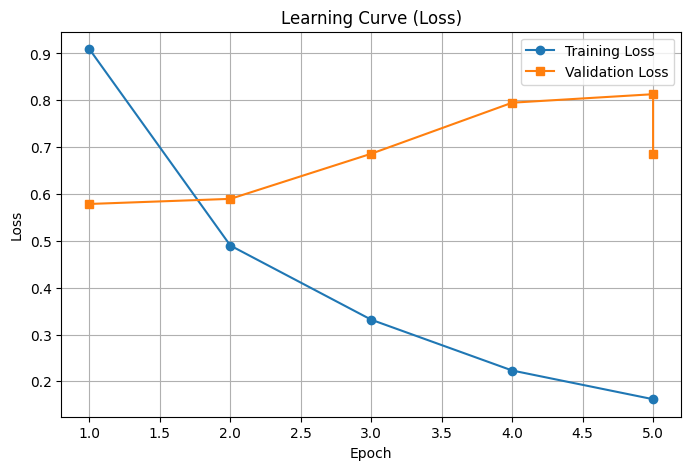

In [16]:
import matplotlib.pyplot as plt

logs = best_trainer.state.log_history

# Training und Validation Loss extrahieren
train_loss = [x["loss"] for x in logs if "loss" in x and "epoch" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]
epochs_train = [x["epoch"] for x in logs if "loss" in x and "epoch" in x]
epochs_eval = [x["epoch"] for x in logs if "eval_loss" in x]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_train, train_loss, label="Training Loss", marker='o')
plt.plot(epochs_eval, eval_loss, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.grid(True)
plt.show()
